In [14]:
#########################
# Example for using fermionic operators
# in the VMC framework
#########################

# VMC
import jVMC
import jVMC.nets as nets
import jVMC.operator as op
from jVMC.operator import number, creation, annihilation
import jVMC.sampler
from jVMC.util import ground_state_search, measure
from jVMC.vqs import NQS
from jVMC.stats import SampledObs
from jVMC import global_defs

# python stuff
import functools

# jax
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import flax.linen as nn

import jax.random as random

# numpy
import numpy as np

# plotting
import matplotlib.pyplot as plt

#########################
# check against openfermion
#########################

import openfermion as of
from openfermion.ops import FermionOperator as fop
from openfermion.linalg import get_sparse_operator

In [15]:
##########################
# custon tarbget wave function
# specific to openfermion compatibility
class Target(nn.Module):
  """Target wave function, returns a vector with the same dimension as the Hilbert space

    Initialization arguments:
        * ``L``: System size
        * ``d``: local Hilbert space dimension
        * ``delta``: small number to avoid log(0)

    """
  L: int
  d: float = 2.00
  delta: float = 1e-15

  @nn.compact
  def __call__(self, s):
    kernel = self.param('kernel',
                        nn.initializers.constant(1),
                        (int(self.d**self.L)))
    # return amplitude for state s
    idx = ((self.d**jnp.arange(self.L)).dot(s[::-1])).astype(int) # NOTE that the state is reversed to account for different bit conventions used in openfermion
    return jnp.log(abs(kernel[idx]+self.delta)) + 1.j*jnp.angle(kernel[idx]) 

## Fermionic operators

Fermionic operators have to satisfy the following condition
$$
\lbrace \hat{c}^\dagger_i, \hat{c}_j\rbrace  = \delta_{ij} \; ,
$$
where $i,j$ are so-called *flavours*.As is done in 'openfermoin' we do not allow for a spin quantum number. In other words, all our fermionic operators can only carry a single flavour. For higher flavour indeces one has combine several distinct fermionis.

The key to realizing fermions is the Jordan-Wigner factor. Every fermionic state is constructed using a filling order, then we have to count how many craetion operatros a given operator has to commute thorugh to arrive at his filling order position.
We can achieve this as follows.
$$
\hat{c}^\dagger\vert 1, 0 \rangle = (-1)^\Omega \vert 1,1\rangle
$$
with 
$$
\Omega = \sum^{j-1}_{i=0} s_i \; .
$$
In the following we construct the repulsive Hubbard Model on a chain as an example and compare it to openfermion
$$
H =  U \sum^N_{i=1} \hat{n}_{i\uparrow}\hat{n}_{i\downarrow}  + t \sum^{N-1}_{i=1}  \hat{c}^\dagger_{\sigma i} \hat{c}_{\sigma i+1} + h.c.  \;.
$$ 

In [16]:
#########################
# jVMC hamiltonian
#########################
t = - 1.0 # hopping
mu = -2.0 # chemical potential
V = 4.0 # interaction
L = 4   # number of sites
flavour = 2 # number of flavours
flavourL = flavour*L # number of spins time

# initalize the Hamitonian
hamiltonian = op.BranchFreeOperator()
# impurity definitions
site1UP = 0
site1DO = flavourL-1#//flavour
# loop over the 1d lattice
for i in range(0,flavourL//flavour):
    # interaction
    hamiltonian.add(op.scal_opstr( V, ( number(site1UP + i) , number(site1DO - i) ) ) )
    # chemical potential
    hamiltonian.add(op.scal_opstr(mu , ( number(site1UP + i) ,) ) )
    hamiltonian.add(op.scal_opstr(mu , ( number(site1DO - i) ,) ) )
    if i == flavourL//flavour-1:
        continue
    # up chain hopping
    hamiltonian.add(op.scal_opstr( t, ( annihilation(site1UP + i) ,creation(site1UP + i + 1)  ) ) )
    hamiltonian.add(op.scal_opstr( t, ( annihilation(site1UP + i + 1) ,creation(site1UP + i)  ) ) )
    # down chain hopping
    hamiltonian.add(op.scal_opstr( t, ( annihilation(site1DO - i) ,creation(site1DO - i - 1)  ) ) )
    hamiltonian.add(op.scal_opstr( t, ( annihilation(site1DO - i - 1) ,creation(site1DO - i)  ) ) )

In [17]:
#########################
# openfermion
#########################

H = 0.0*fop()
# loop over the 1d lattice
for i in range(0,flavourL//flavour):
    H += fop(((site1UP + i,1),(site1UP + i,0),(site1DO - i,1),(site1DO - i,0)),V) 
    H += fop(((site1UP + i,1),(site1UP + i,0)),mu) + fop(((site1DO - i,1),(site1DO - i,0)),mu)
    if i == flavourL//flavour-1:
        continue
    # up chain
    H += (fop(((site1UP + i,1),(site1UP + i + 1,0)),t) + fop(((site1UP + i + 1,1),(site1UP + i,0)),t))
    # down chain
    H += (fop(((site1DO - i,1),(site1DO - i - 1,0)),t) + fop(((site1DO - i - 1,1),(site1DO - i,0)),t))

In [18]:
#########################
# diagonalize the Openfermion Hamiltonain
#########################

ham = get_sparse_operator(H)
a, b = np.linalg.eigh(ham.toarray())

chi_model = Target(L=flavourL, d=2)
chi = NQS(chi_model)
chi(jnp.array(jnp.ones((1, 1, flavourL))))
chi.set_parameters(b[:,0]+1e-14)
chiSampler = jVMC.sampler.ExactSampler(chi, (flavourL,))

In [19]:
s, logPsi, p = chiSampler.sample()
sPrime, _ = hamiltonian.get_s_primes(s)
Oloc = hamiltonian.get_O_loc(s, chi, logPsi)
Omean = jVMC.mpi_wrapper.global_mean(Oloc,p)

print("Ground state energy: \njVMC: %.8f, Openfermion: %.8f"%(Omean.real,a[0]))

Ground state energy: 
jVMC: -9.95314531, Openfermion: -9.95314531


### Finding the ground state brute force

In [20]:
# Set up variational wave function
all_states = Target(L=flavourL, d=2)
psi = NQS(all_states)
# initialize NQS
print("Net init: ",psi(jnp.array(jnp.ones((1, 1, flavourL)))))
# Set up exact sampler
exactSampler = jVMC.sampler.ExactSampler(psi, flavourL)

Net init:  [[1.11022302e-15+0.j]]


0 -7.000000000000001 5.5
1 -7.467301577096615 4.201406205379573
2 -7.825686309983262 3.2523101664230114
3 -8.10483621680366 2.5694595575910926
4 -8.326884531104772 2.074288320605861
5 -8.507340117801467 1.7085314071736302
6 -8.656904891826237 1.4324015316614156
7 -8.783017779125638 1.2194070685873446
8 -8.890944501517287 1.051903494891513
9 -8.984498515994046 0.917965281287074
10 -9.066506571102735 0.8093336959332833
11 -9.139107724304006 0.7201156140160946
12 -9.203947118775915 0.6459759470850717
13 -9.262304551816202 0.5836417294396691
14 -9.315182960980167 0.5305960391856608
15 -9.363372045046459 0.484883968772506
16 -9.407495960126163 0.4449833257385781
17 -9.44805024639765 0.4097126509529765
18 -9.485430969003714 0.3781614100585271
19 -9.519957868620171 0.34963433951197503
20 -9.551892694153976 0.32360581762742835
21 -9.581453570991334 0.29968210948301854
22 -9.608826090793954 0.27757025669458835
23 -9.634171709889351 0.25705276395648746
24 -9.65763397107991 0.23796736572468966
25

Text(0.5, 0, 'iteration')

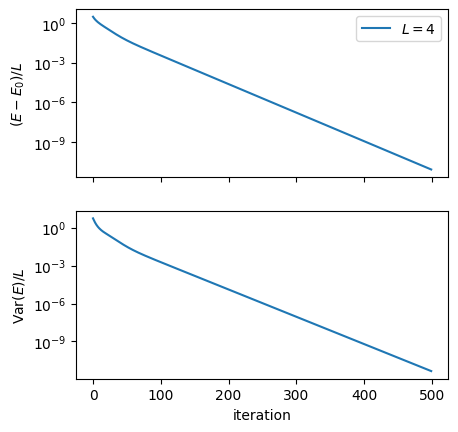

In [21]:
# Set up sampler
sampler = jVMC.sampler.ExactSampler(psi, flavourL)

# Set up TDVP
tdvpEquation = jVMC.util.tdvp.TDVP(sampler, rhsPrefactor=1.,diagonalShift=10, makeReal='real')

stepper = jVMC.util.stepper.Euler(timeStep=5e-1)  # ODE integrator

n_steps = 500
res = []
for n in range(n_steps):

    dp, _ = stepper.step(0, tdvpEquation, psi.get_parameters(), hamiltonian=hamiltonian, psi=psi, numSamples=None)
    psi.set_parameters(dp)

    print(n, jax.numpy.real(tdvpEquation.ElocMean0), tdvpEquation.ElocVar0)

    res.append([n, jax.numpy.real(tdvpEquation.ElocMean0), tdvpEquation.ElocVar0])

res = np.array(res)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=[4.8, 4.8])
ax[0].semilogy(res[:, 0], res[:, 1] - a[0], '-', label=r"$L=" + str(L) + "$")
ax[0].set_ylabel(r'$(E-E_0)/L$')

ax[1].semilogy(res[:, 0], res[:, 2], '-')
ax[1].set_ylabel(r'Var$(E)/L$')
ax[0].legend()
plt.xlabel('iteration')

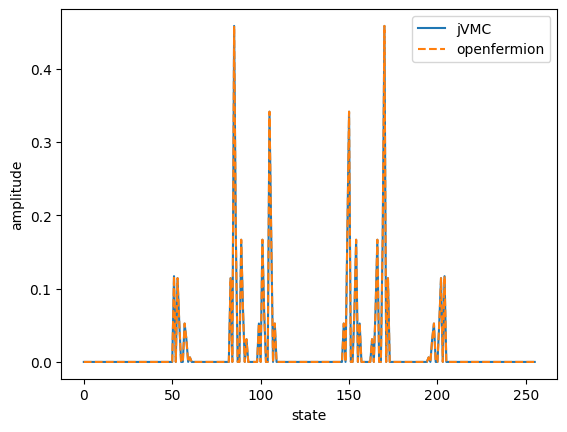

In [22]:
s, logPsi, _ = exactSampler.sample()
var_wf = np.real(np.exp(logPsi))[0]
# normalizing the wave function
var_wf /= var_wf.dot(var_wf)**0.5

figure = plt.figure(dpi=100)
plt.xlabel('state')
plt.ylabel('amplitude')
plt.plot(var_wf,label='jVMC')
plt.plot(np.exp(chi(s)).real[0],'--',label='openfermion')
plt.legend()